In [1]:
import argparse
import numpy as np
import os
import sys
import yaml
import torch
import torchmetrics

from argparse import Namespace
from lib import utils
from lib.utils import load_graph_data
from model.pytorch.dcrnn_supervisor import DCRNNSupervisor

In [2]:
def get_supervisor(config_filename, model_path):
    args = Namespace(
        use_cpu_only = False,
        config_filename=config_filename
    )
    
    with open(args.config_filename) as f:
        supervisor_config = yaml.load(f)
        
        graph_pkl_filename = supervisor_config['data'].get('graph_pkl_filename')
        sensor_ids, sensor_id_to_ind, adj_mx = load_graph_data(graph_pkl_filename)
        
        supervisor = DCRNNSupervisor(adj_mx = adj_mx, **supervisor_config)
        supervisor._setup_graph()
        
        checkpoint = torch.load(model_path, map_location='cpu')
        supervisor.dcrnn_model.load_state_dict(checkpoint['model_state_dict'])
        
        return supervisor

In [3]:
def get_prediction_data(supervisor):
    with torch.no_grad():
        supervisor.dcrnn_model = supervisor.dcrnn_model.eval()
        
        val_iterator = supervisor._data['test_loader'].get_iterator()
        y_preds = []
        
        for _, (x, y) in enumerate(val_iterator):
            x, y = supervisor._prepare_data(x, y)
            output = supervisor.dcrnn_model(x)
            y_preds.append(output.cpu())
            
        y_preds = np.concatenate(y_preds, axis=1)
        y_preds_scaled = []
        
        for t in range(y_preds.shape[0]):
            y_pred = supervisor.standard_scaler.inverse_transform(y_preds[t])
            y_preds_scaled.append(y_pred)
            
        return y_preds_scaled

In [4]:
def get_truth_data(supervisor, dataset_dir):
    supervisor._data = utils.load_dataset(dataset_dir = dataset_dir, 
                                          batch_size = 64, 
                                          val_batch_size = 64,
                                          test_batch_size=64)
    supervisor.standard_scaler = supervisor._data['scaler']
    val_iterator = supervisor._data['test_loader'].get_iterator()
    y_truths = []
    
    for _, (x, y) in enumerate(val_iterator):
        x, y = supervisor._prepare_data(x, y)
        y_truths.append(y.cpu())
    y_truths = np.concatenate(y_truths, axis=1)
    y_truth_scaled = []
    
    for t in range(y_truths.shape[0]):
        y_truth = supervisor.standard_scaler.inverse_transform(y_truths[t])
        y_truth_scaled.append(y_truth)
        
    return y_truth_scaled

In [5]:
def evaluation(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [6]:
supervisor = get_supervisor('data/model/dcrnn_virtual_0.yaml', 'models/virtual_0/epo27.tar')
y_pred = get_prediction_data(supervisor)
print('Virtual Drop 0%')

2023-05-18 16:18:12,075 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0518161812/


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_42132\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2023-05-18 16:18:13,153 - INFO - Model created
Virtual Drop 0%


In [7]:
y_true = get_truth_data(supervisor, 'data/virtual_0')

In [8]:
def evaluation(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=df.columns)
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [16]:
import pandas as pd

In [17]:
df = pd.read_csv('virtual_drop_0.csv').drop(columns=['Unnamed: 0'])

In [12]:
evaluation(y_pred, y_true)

2
15 Min
MAE: tensor(2.2870) RMSE: tensor(3.3155) MAPE: 9.948838787314331 MAPE2: tensor(9.9488)
5
30 Min
MAE: tensor(2.5696) RMSE: tensor(3.6107) MAPE: 11.207577034279153 MAPE2: tensor(11.2076)
8
45 Min
MAE: tensor(2.7871) RMSE: tensor(3.8420) MAPE: 12.087794880808135 MAPE2: tensor(12.0878)
11
60 Min
MAE: tensor(2.9748) RMSE: tensor(4.0459) MAPE: 12.833192613389757 MAPE2: tensor(12.8332)


In [13]:
def evaluation_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=df.columns)
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [14]:
evaluation_only(y_pred, y_true)

2
15 Min
MAE: tensor(2.1630) RMSE: tensor(3.2766) MAPE: 8.98028328305199 MAPE2: tensor(8.9803)
5
30 Min
MAE: tensor(2.4585) RMSE: tensor(3.6091) MAPE: 10.180061582535032 MAPE2: tensor(10.1801)
8
45 Min
MAE: tensor(2.7032) RMSE: tensor(3.8500) MAPE: 11.16189199780661 MAPE2: tensor(11.1619)
11
60 Min
MAE: tensor(2.9367) RMSE: tensor(4.0852) MAPE: 12.14659327552432 MAPE2: tensor(12.1466)


In [15]:
supervisor = get_supervisor('data/model/dcrnn_virtual_5.yaml', 'models/virtual_5/epo30.tar')
y_pred = get_prediction_data(supervisor)
#y_true = get_truth_data(supervisor, 'data/virtual_0')
print('virtual 5%')

2023-05-18 16:18:28,945 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0518161828/
2023-05-18 16:18:28,945 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0518161828/
2023-05-18 16:18:29,095 - INFO - Model created
2023-05-18 16:18:29,095 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_42132\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)
D:\DCRNN_drop\lib\utils.py:104: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(d, -1).flatten()


virtual 5%


In [16]:
def evaluation_5(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        
        remove_columns = ['1220025300', '1220029900']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [17]:
evaluation_5(y_pred, y_true)

15 Min
MAE: tensor(3.1282) RMSE: tensor(4.4480) MAPE: 13.786618503523462 MAPE2: tensor(13.7866)
30 Min
MAE: tensor(3.3074) RMSE: tensor(4.5817) MAPE: 14.536261852876638 MAPE2: tensor(14.5363)
45 Min
MAE: tensor(3.4779) RMSE: tensor(4.7467) MAPE: 15.196385795687451 MAPE2: tensor(15.1964)
60 Min
MAE: tensor(3.6427) RMSE: tensor(4.9109) MAPE: 15.861697255829235 MAPE2: tensor(15.8617)


In [25]:
def evaluation_5_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        remove_columns = ['1220025300', '1220029900']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
                
        #columns = ['1220025300', '1220029900']
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [24]:
evaluation_5_only(y_pred, y_true)

2
15 Min
MAE: tensor(4.3359) RMSE: tensor(4.9352) MAPE: 18.331684006585014 MAPE2: tensor(18.3317)
5
30 Min
MAE: tensor(4.3228) RMSE: tensor(4.9378) MAPE: 18.22739972008599 MAPE2: tensor(18.2274)
8
45 Min
MAE: tensor(4.3349) RMSE: tensor(4.9973) MAPE: 18.08817254172431 MAPE2: tensor(18.0882)
11
60 Min
MAE: tensor(4.3525) RMSE: tensor(5.0135) MAPE: 18.077941735585533 MAPE2: tensor(18.0779)


In [26]:
evaluation_5_only(y_pred, y_true)

2
15 Min
MAE: tensor(2.9817) RMSE: tensor(4.0607) MAPE: 12.585436351715574 MAPE2: tensor(12.5854)
5
30 Min
MAE: tensor(3.1740) RMSE: tensor(4.2578) MAPE: 13.31776361616831 MAPE2: tensor(13.3178)
8
45 Min
MAE: tensor(3.3578) RMSE: tensor(4.4248) MAPE: 13.982609340122767 MAPE2: tensor(13.9826)
11
60 Min
MAE: tensor(3.5220) RMSE: tensor(4.5472) MAPE: 14.652062976171102 MAPE2: tensor(14.6521)


In [27]:
supervisor = get_supervisor('data/model/dcrnn_virtual_20.yaml', 'models/virtual_20/epo50.tar')
y_pred = get_prediction_data(supervisor)
#y_true = get_truth_data(supervisor, 'data/virtual_0')
print('virtual 20%')

2023-05-18 16:21:23,935 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0518162123/
2023-05-18 16:21:23,935 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0518162123/
2023-05-18 16:21:23,935 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0518162123/
2023-05-18 16:21:24,093 - INFO - Model created
2023-05-18 16:21:24,093 - INFO - Model created
2023-05-18 16:21:24,093 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_42132\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)
D:\DCRNN_drop\lib\utils.py:104: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(d, -1).flatten()


virtual 20%


In [30]:
def evaluation_20(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        remove_columns = ['1220025300', '1220029900','1220026000','1220024700',
                         '1220022300','1220026100','1220029000']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        predDf['1220026000'] = (predDf['1220024600_0'] + predDf['1220025200_2'])/2
        predDf['1220024700'] = (predDf['1220025800_0'] + predDf['1220027700_1'])/2
        predDf['1220022300'] = (predDf['1220023000_1'] + predDf['1220020600_3'])/2
        predDf['1220026100'] = (predDf['1220029100_1'] + predDf['1220029900_3'])/2
        predDf['1220029000'] = (predDf['1220023100_0'] + predDf['1220025500_2'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [31]:
evaluation_20(y_pred, y_true)

2
15 Min
MAE: tensor(5.0998) RMSE: tensor(6.7405) MAPE: 22.35378689236111 MAPE2: tensor(22.3538)
5
30 Min
MAE: tensor(5.1798) RMSE: tensor(6.7940) MAPE: 22.536023457845054 MAPE2: tensor(22.5360)
8
45 Min
MAE: tensor(5.2540) RMSE: tensor(6.8446) MAPE: 22.71646099326051 MAPE2: tensor(22.7165)
11
60 Min
MAE: tensor(5.3513) RMSE: tensor(6.9526) MAPE: 23.032084806465807 MAPE2: tensor(23.0321)


In [32]:
def evaluation_20_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        remove_columns = ['1220025300', '1220029900','1220026000','1220024700',
                         '1220022300','1220026100','1220029000']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        predDf['1220026000'] = (predDf['1220024600_0'] + predDf['1220025200_2'])/2
        predDf['1220024700'] = (predDf['1220025800_0'] + predDf['1220027700_1'])/2
        predDf['1220022300'] = (predDf['1220023000_1'] + predDf['1220020600_3'])/2
        predDf['1220026100'] = (predDf['1220029100_1'] + predDf['1220029900_3'])/2
        predDf['1220029000'] = (predDf['1220023100_0'] + predDf['1220025500_2'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
                
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)
        
    return predDf, trueDf

In [33]:
p, t = evaluation_20_only(y_pred, y_true)

2
15 Min
MAE: tensor(8.0222) RMSE: tensor(9.7394) MAPE: 31.15222870357453 MAPE2: tensor(31.1522)
5
30 Min
MAE: tensor(8.0518) RMSE: tensor(9.8122) MAPE: 31.101299467540922 MAPE2: tensor(31.1013)
8
45 Min
MAE: tensor(8.1125) RMSE: tensor(9.9024) MAPE: 31.200072878883 MAPE2: tensor(31.2001)
11
60 Min
MAE: tensor(8.2108) RMSE: tensor(9.9744) MAPE: 31.539611210898748 MAPE2: tensor(31.5396)


In [36]:
real = y_true[-1]
prediction = y_pred[-1]

remove_columns = ['1220025300', '1220029900','1220026000','1220024700',
                         '1220022300','1220026100','1220029000']
cols = df.columns.drop(remove_columns)

trueDf = pd.DataFrame(real, columns=df.columns)
predDf = pd.DataFrame(prediction, columns=cols)

predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2

In [40]:
trueDf[['1220027600_2', '1220031100_3']]

,1220027600_2,1220031100_3
0,26.320040,26.845289
1,24.242279,24.370251
2,26.985229,26.857260
3,25.392555,25.358175
4,26.780636,26.983095
...,...,...
571,25.277500,24.330139
572,25.277500,24.330139
573,25.277500,24.330139
574,25.277500,24.330139


In [41]:
trueDf[['1220031100', '1220027600', '1220029000', '1220030100']]

,1220031100,1220027600,1220029000,1220030100
0,22.799999,28.430000,25.100000,27.850000
1,27.559999,22.389999,24.290001,24.959999
2,24.400000,32.790001,23.980000,23.309999
3,27.030001,27.059999,23.790001,23.610001
4,27.270000,30.299999,23.870001,24.930000
...,...,...,...,...
571,25.100000,25.139999,26.959999,22.000000
572,25.100000,25.139999,26.959999,22.000000
573,25.100000,25.139999,26.959999,22.000000
574,25.100000,25.139999,26.959999,22.000000


In [38]:
predDf[['1220027600_2', '1220031100_3']]

,1220027600_2,1220031100_3
0,14.719027,23.427786
1,14.523432,22.484438
2,14.583050,22.395065
3,14.811394,23.870001
4,14.964300,24.682917
...,...,...
571,13.551627,19.668926
572,13.551627,19.668926
573,13.551627,19.668926
574,13.551627,19.668926


In [43]:
predDf[['1220031100', '1220027600', '1220030100']]#, '1220030100']]

,1220031100,1220027600,1220030100
0,26.808481,22.659319,32.614197
1,26.292141,23.191225,33.247063
2,26.981400,22.368090,32.760582
3,25.765261,22.338800,35.853836
4,25.938717,21.751331,34.657314
...,...,...,...
571,25.970875,23.968451,25.270079
572,25.970875,23.968451,25.270079
573,25.970875,23.968451,25.270079
574,25.970875,23.968451,25.270079


In [44]:
import matplotlib.pyplot as plt

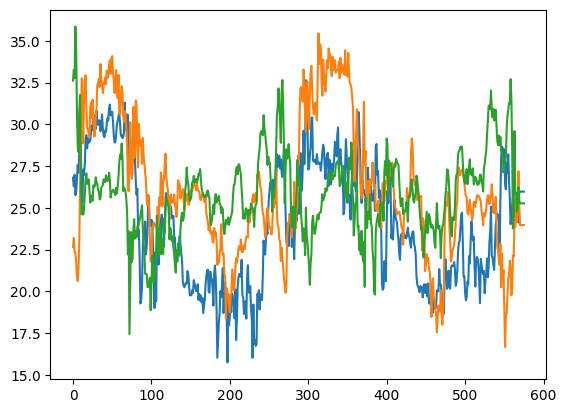

In [45]:
plt.plot(predDf[['1220031100', '1220027600', '1220030100']])

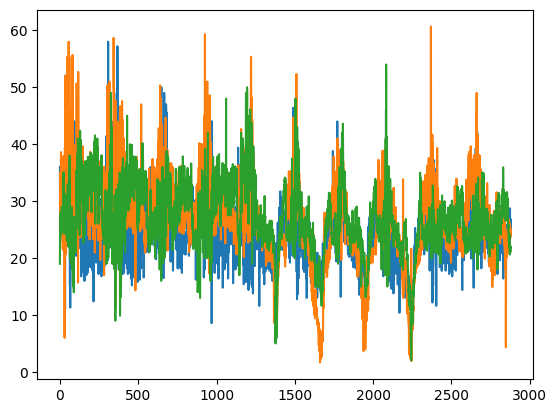

In [58]:
plt.plot(df[['1220031100', '1220027600', '1220030100']])

In [ ]:
Do Test:
    1000까지만 잘라서 test

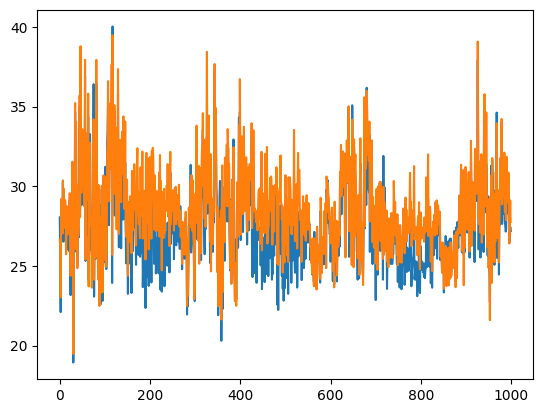

In [67]:
plt.plot(df[['1220027600_2', '1220031100_3']][:1000])

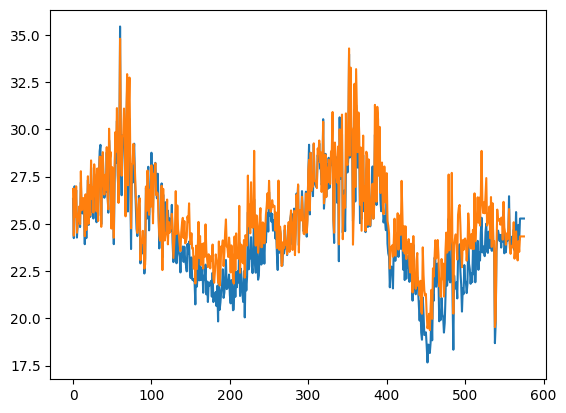

In [53]:
plt.plot(trueDf[['1220027600_2', '1220031100_3']])

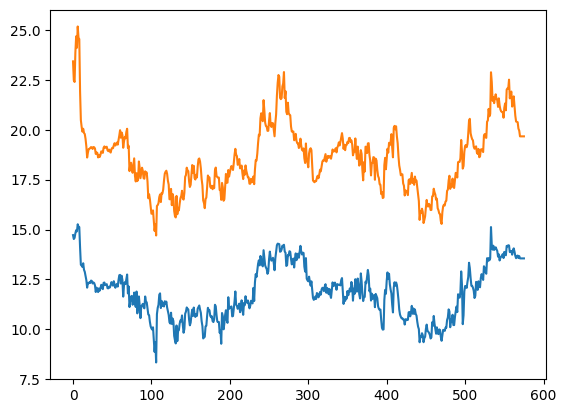

In [46]:
plt.plot(predDf[['1220027600_2', '1220031100_3']])

In [61]:
la = pd.read_csv('speed_la.csv').drop(columns=['Unnamed: 0'])
la

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
4,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34267,65.000000,65.888889,68.555556,61.666667,32.833333,54.555556,62.444444,63.333333,59.222222,65.333333,...,52.888889,69.000000,65.111111,55.666667,66.333333,62.444444,66.777778,64.888889,69.666667,62.333333
34268,61.375000,65.625000,66.500000,62.750000,32.833333,50.500000,62.000000,67.000000,65.250000,67.125000,...,54.000000,69.250000,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000
34269,67.000000,59.666667,69.555556,61.000000,32.833333,44.777778,64.222222,63.777778,59.777778,57.666667,...,51.333333,67.888889,64.333333,57.000000,66.000000,62.666667,68.666667,63.333333,67.444444,61.222222
34270,66.750000,62.250000,66.000000,59.625000,32.833333,53.000000,64.285714,64.125000,60.875000,66.250000,...,51.125000,69.375000,61.625000,60.500000,65.625000,66.375000,69.500000,63.000000,67.875000,63.500000


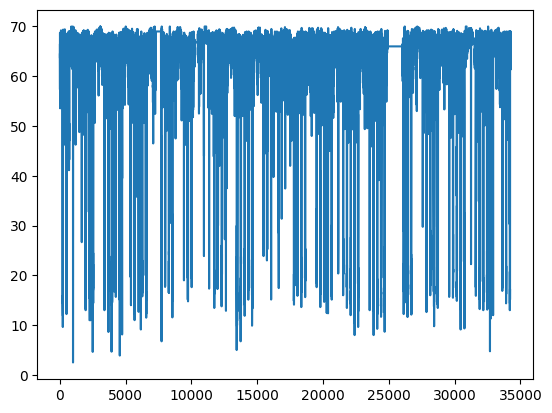

In [62]:
plt.plot(la['773869'])

In [34]:
p

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,25.588640,19.073406,20.042582,14.813156,20.926867,13.174963,23.891663
1,26.439331,18.503935,20.502844,14.876291,21.165411,13.130803,24.452248
2,27.269203,18.489058,20.278561,14.839720,21.181213,12.976292,24.994629
3,27.784008,19.340698,22.075626,15.339170,21.822882,12.912081,25.523432
4,27.751675,19.823608,22.346214,15.157795,21.190868,13.062131,27.018164
...,...,...,...,...,...,...,...
571,27.821476,16.610277,20.478077,14.859941,26.529804,14.347912,28.560658
572,27.821476,16.610277,20.478077,14.859941,26.529804,14.347912,28.560658
573,27.821476,16.610277,20.478077,14.859941,26.529804,14.347912,28.560658
574,27.821476,16.610277,20.478077,14.859941,26.529804,14.347912,28.560658


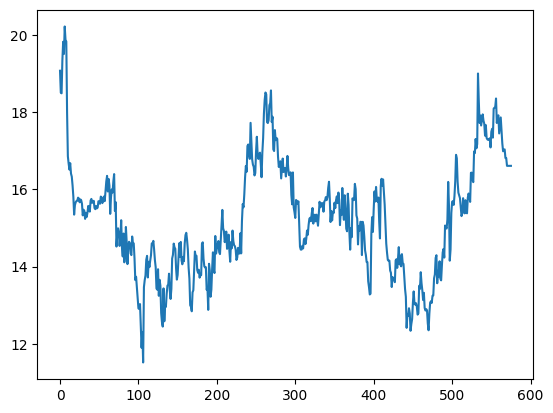

In [48]:
plt.plot(p['1220029900'])

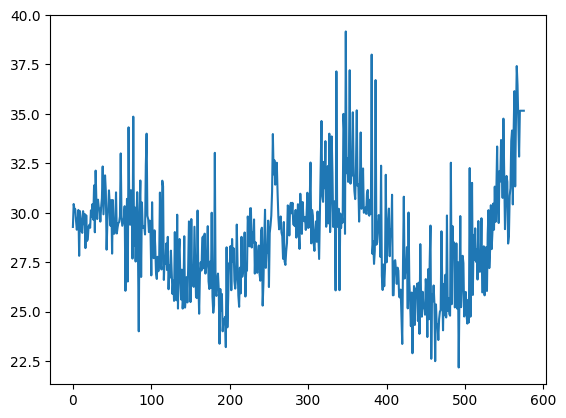

In [52]:
plt.plot(t['1220029900'])

In [35]:
t

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,22.420000,29.280001,27.000000,21.830000,26.549999,25.309999,25.100000
1,23.820000,30.440001,25.000000,23.100000,26.490000,26.020000,24.290001
2,26.620001,30.180000,24.610001,24.219999,24.139999,22.580000,23.980000
3,26.200001,30.180000,28.860001,24.629999,32.090000,25.209999,23.790001
4,27.480000,29.590000,29.040001,22.360001,30.309999,27.540001,23.870001
...,...,...,...,...,...,...,...
571,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
572,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
573,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
574,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999


In [ ]:
#Compare Model (node = 36)

In [64]:
def evaluation(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [72]:
def evaluation_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=dfs.columns)
        predDf = pd.DataFrame(prediction, columns=dfs.columns)
                
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [34]:
def get_truth_data(supervisor, dataset_dir):
    supervisor._data = utils.load_dataset(dataset_dir = dataset_dir, 
                                          batch_size = 32, 
                                          val_batch_size = 32,
                                          test_batch_size=32)
    supervisor.standard_scaler = supervisor._data['scaler']
    val_iterator = supervisor._data['test_loader'].get_iterator()
    y_truths = []
    
    for _, (x, y) in enumerate(val_iterator):
        x, y = supervisor._prepare_data(x, y)
        y_truths.append(y.cpu())
    y_truths = np.concatenate(y_truths, axis=1)
    y_truth_scaled = []
    
    for t in range(y_truths.shape[0]):
        y_truth = supervisor.standard_scaler.inverse_transform(y_truths[t])
        y_truth_scaled.append(y_truth)
        
    return y_truth_scaled

In [35]:
supervisor = get_supervisor('data/model/dcrnn_virtual_1000_0.yaml', 'models/v1000_0/epo9.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/v1000_0')
print('v_1000 0%')
#evaluation(y_pred, y_true)
#evaluation_only(y_pred, y_true)

2023-05-18 18:44:18,300 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184418/
2023-05-18 18:44:18,300 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184418/
2023-05-18 18:44:18,300 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184418/
2023-05-18 18:44:18,389 - INFO - Model created
2023-05-18 18:44:18,389 - INFO - Model created
2023-05-18 18:44:18,389 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_50064\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


v_1000 0%


In [36]:
def evaluation(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=df.columns)
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)
        
        

In [37]:
def evaluation_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=df.columns)
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [38]:
y_pred[0].shape, y_true[0].shape

((224, 72), (224, 72))

In [40]:
evaluation(y_pred, y_true)
evaluation_only(y_pred, y_true)

2
15 Min
MAE: tensor(2.9898) RMSE: tensor(4.3205) MAPE: 10.899687570238871 MAPE2: tensor(10.8997)
5
30 Min
MAE: tensor(3.0940) RMSE: tensor(4.3679) MAPE: 11.295716724698506 MAPE2: tensor(11.2957)
8
45 Min
MAE: tensor(3.3188) RMSE: tensor(4.6227) MAPE: 12.04161492605058 MAPE2: tensor(12.0416)
11
60 Min
MAE: tensor(3.4863) RMSE: tensor(4.7324) MAPE: 12.711970011393229 MAPE2: tensor(12.7120)
2
15 Min
MAE: tensor(3.0046) RMSE: tensor(4.1734) MAPE: 10.145236034782565 MAPE2: tensor(10.1452)
5
30 Min
MAE: tensor(3.1331) RMSE: tensor(4.3186) MAPE: 10.551368946931799 MAPE2: tensor(10.5514)
8
45 Min
MAE: tensor(3.3181) RMSE: tensor(4.5944) MAPE: 11.430794852120536 MAPE2: tensor(11.4308)
11
60 Min
MAE: tensor(3.4872) RMSE: tensor(4.7341) MAPE: 11.84997169338927 MAPE2: tensor(11.8500)


In [44]:
supervisor = get_supervisor('data/model/dcrnn_virtual_1000_5.yaml', 'models/v1000_5/epo2.tar')
y_pred = get_prediction_data(supervisor)
#y_true = get_truth_data(supervisor, 'data/v1000_0')
print('v_1000 5%')

2023-05-18 18:45:14,159 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184514/
2023-05-18 18:45:14,159 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184514/
2023-05-18 18:45:14,159 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184514/
2023-05-18 18:45:14,159 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184514/
2023-05-18 18:45:14,159 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184514/
2023-05-18 18:45:14,240 - INFO - Model created
2023-05-18 18:45:14,240 - INFO - Model created
2023-05-18 18:45:14,240 - INFO - Model created
2023-05-18 18:45:14,240 - INFO - Model created
2023-05-18 18:45:14,240 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_50064\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


v_1000 5%


In [45]:
def evaluation_5(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        
        remove_columns = ['1220025300', '1220029900']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [46]:
def evaluation_5_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        remove_columns = ['1220025300', '1220029900']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
                
        #columns = ['1220025300', '1220029900']
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [47]:
evaluation_5(y_pred, y_true)
evaluation_5_only(y_pred, y_true)

15 Min
MAE: tensor(3.7901) RMSE: tensor(5.2895) MAPE: 13.790018596346416 MAPE2: tensor(13.7900)
30 Min
MAE: tensor(3.8774) RMSE: tensor(5.3651) MAPE: 14.06232440282428 MAPE2: tensor(14.0623)
45 Min
MAE: tensor(3.9646) RMSE: tensor(5.3996) MAPE: 14.323387448749845 MAPE2: tensor(14.3234)
60 Min
MAE: tensor(3.9336) RMSE: tensor(5.4319) MAPE: 14.253990233890592 MAPE2: tensor(14.2540)
2
15 Min
MAE: tensor(3.8252) RMSE: tensor(5.0297) MAPE: 13.025955278046277 MAPE2: tensor(13.0260)
5
30 Min
MAE: tensor(3.8422) RMSE: tensor(5.2180) MAPE: 12.970256805419922 MAPE2: tensor(12.9703)
8
45 Min
MAE: tensor(3.8881) RMSE: tensor(5.1488) MAPE: 13.398397212125818 MAPE2: tensor(13.3984)
11
60 Min
MAE: tensor(3.9169) RMSE: tensor(5.1790) MAPE: 13.351179628956075 MAPE2: tensor(13.3512)


In [48]:
supervisor = get_supervisor('data/model/dcrnn_virtual_1000_20.yaml', 'models/v1000_20/epo2.tar')
y_pred = get_prediction_data(supervisor)
#y_true = get_truth_data(supervisor, 'data/v1000_0')
print('v_1000 20%')

2023-05-18 18:46:05,019 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184605/
2023-05-18 18:46:05,019 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184605/
2023-05-18 18:46:05,019 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184605/
2023-05-18 18:46:05,019 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184605/
2023-05-18 18:46:05,019 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184605/
2023-05-18 18:46:05,019 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_32_0518184605/
2023-05-18 18:46:05,101 - INFO - Model created
2023-05-18 18:46:05,101 - INFO - Model created
2023-05-18 18:46:05,101 - INFO - Model created
2023-05-18 18:46:05,101 - INFO - Model created
2023-05-18 18:46:05,101 - INFO - Model created
2023-05-18 18:46:05,101 - INFO - Model created


C:\Users\vfgtr554\AppData\Local\Temp\ipykernel_50064\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)
D:\DCRNN_drop\lib\utils.py:104: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(d, -1).flatten()


v_1000 20%


In [49]:
def evaluation_20(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        remove_columns = ['1220025300', '1220029900','1220026000','1220024700',
                         '1220022300','1220026100','1220029000']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        predDf['1220026000'] = (predDf['1220024600_0'] + predDf['1220025200_2'])/2
        predDf['1220024700'] = (predDf['1220025800_0'] + predDf['1220027700_1'])/2
        predDf['1220022300'] = (predDf['1220023000_1'] + predDf['1220020600_3'])/2
        predDf['1220026100'] = (predDf['1220029100_1'] + predDf['1220029900_3'])/2
        predDf['1220029000'] = (predDf['1220023100_0'] + predDf['1220025500_2'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [50]:
def evaluation_20_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        remove_columns = ['1220025300', '1220029900','1220026000','1220024700',
                         '1220022300','1220026100','1220029000']
        cols = df.columns.drop(remove_columns)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=cols)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        predDf['1220026000'] = (predDf['1220024600_0'] + predDf['1220025200_2'])/2
        predDf['1220024700'] = (predDf['1220025800_0'] + predDf['1220027700_1'])/2
        predDf['1220022300'] = (predDf['1220023000_1'] + predDf['1220020600_3'])/2
        predDf['1220026100'] = (predDf['1220029100_1'] + predDf['1220029900_3'])/2
        predDf['1220029000'] = (predDf['1220023100_0'] + predDf['1220025500_2'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
                
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)
        
    return predDf, trueDf

In [53]:
evaluation_20(y_pred, y_true)
p, t = evaluation_20_only(y_pred, y_true)

2
15 Min
MAE: tensor(5.6858) RMSE: tensor(7.6289) MAPE: 20.915096525161985 MAPE2: tensor(20.9151)
5
30 Min
MAE: tensor(5.6216) RMSE: tensor(7.5538) MAPE: 20.683618575807603 MAPE2: tensor(20.6836)
8
45 Min
MAE: tensor(5.6241) RMSE: tensor(7.5342) MAPE: 20.655825781443763 MAPE2: tensor(20.6558)
11
60 Min
MAE: tensor(5.7309) RMSE: tensor(7.6370) MAPE: 21.118241264706565 MAPE2: tensor(21.1182)
2
15 Min
MAE: tensor(9.4221) RMSE: tensor(11.1924) MAPE: 31.18075740580656 MAPE2: tensor(31.1808)
5
30 Min
MAE: tensor(9.5836) RMSE: tensor(11.1352) MAPE: 31.77021182313257 MAPE2: tensor(31.7702)
8
45 Min
MAE: tensor(9.4091) RMSE: tensor(11.0247) MAPE: 31.455863251978037 MAPE2: tensor(31.4559)
11
60 Min
MAE: tensor(9.4407) RMSE: tensor(11.1569) MAPE: 31.31813127167371 MAPE2: tensor(31.3181)


In [54]:
p

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,27.785189,17.658794,19.751200,16.370028,21.380390,15.015684,20.456715
1,28.030174,17.827667,19.831230,16.492203,21.328676,15.264555,20.508640
2,27.892883,17.936562,19.558235,16.210024,21.323448,15.105696,20.115250
3,28.086689,17.724800,19.401196,15.984137,21.603664,15.420796,19.908775
4,28.626234,17.442078,19.391558,15.982420,21.129162,15.181980,19.710484
...,...,...,...,...,...,...,...
219,26.090492,18.637852,20.214827,15.590597,29.680988,16.155159,21.154276
220,26.090492,18.637852,20.214827,15.590597,29.680988,16.155159,21.154276
221,26.090492,18.637852,20.214827,15.590597,29.680988,16.155159,21.154276
222,26.090492,18.637852,20.214827,15.590597,29.680988,16.155159,21.154276


In [55]:
t

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,27.720001,31.800001,20.090000,24.040001,17.000000,29.120001,18.860001
1,21.060001,28.930000,23.640001,22.500000,21.340000,32.220001,19.100000
2,23.030001,31.360001,25.960001,21.260000,22.390001,33.480000,18.630001
3,23.390001,28.440001,22.050001,25.610001,22.670000,30.380001,18.950001
4,22.580002,30.740002,22.910000,28.800001,17.000000,31.110001,18.360001
...,...,...,...,...,...,...,...
219,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001
220,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001
221,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001
222,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001


In [100]:
trueDf = pd.DataFrame(y_true[-1], columns = dfs.columns)
predDf = pd.DataFrame(y_pred[-1], columns = dfs.columns)

In [112]:
import random
columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
n1, n2 = random.sample(list(trueDf.columns.drop(columns)), 2)
n1, n2

('1220025900', '1220027500')

Index(['1220026200', '1220022900', '1220019800', '1220023000', '1220026300',
       '1220029700', '1220028200', '1220027200', '1220028300', '1220029100',
       '1220030100', '1220027600', '1220025800', '1220023100', '1220025900',
       '1220027700', '1220031100', '1220027400', '1220024600', '1220021400',
       '1220027500', '1220023900', '1220025500', '1220023800', '1220022200',
       '1220020600', '1220025200', '1220024000', '1220026900'],
      dtype='object')

In [96]:
pp, tt = evaluation_only(y_pred, y_true)

2
15 Min
MAE: tensor(18.6690) RMSE: tensor(19.4361) MAPE: 74.35530405195932 MAPE2: tensor(74.3553)
5
30 Min
MAE: tensor(16.4458) RMSE: tensor(17.3167) MAPE: 64.93911743164062 MAPE2: tensor(64.9391)
8
45 Min
MAE: tensor(14.7985) RMSE: tensor(15.7969) MAPE: 57.895890493241566 MAPE2: tensor(57.8959)
11
60 Min
MAE: tensor(13.6639) RMSE: tensor(14.8346) MAPE: 53.08179098462301 MAPE2: tensor(53.0818)


In [97]:
pp

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,12.510891,17.455742,18.820700,17.455860,19.245670,12.510889,14.634655
1,12.534997,17.295586,18.413599,17.295712,19.788523,12.535000,14.440311
2,12.832245,17.214952,17.379723,17.215160,18.539108,12.832245,14.803255
3,13.734566,17.174292,19.827579,17.174507,18.635704,13.734566,14.937490
4,14.950094,18.246925,20.750587,18.247002,18.168701,14.950092,14.935769
...,...,...,...,...,...,...,...
571,14.611403,19.123451,16.909561,19.123817,14.518284,14.611403,16.215542
572,14.611403,19.123451,16.909561,19.123817,14.518284,14.611403,16.215542
573,14.611403,19.123451,16.909561,19.123817,14.518284,14.611403,16.215542
574,14.611403,19.123451,16.909561,19.123817,14.518284,14.611403,16.215542


In [99]:
p

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,27.073700,17.736574,20.239536,12.598211,22.822577,11.350378,25.002712
1,28.120590,17.660004,20.390446,13.034716,23.755356,11.350268,25.055901
2,28.541222,18.003069,20.911905,13.456710,23.933758,11.214125,26.981670
3,28.748446,18.191887,21.521891,14.099430,23.934727,11.189169,27.749485
4,28.952810,18.116421,21.126272,14.026608,23.593887,11.315218,28.429506
...,...,...,...,...,...,...,...
571,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628
572,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628
573,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628
574,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628


In [98]:
tt

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,22.420000,29.280001,27.000000,21.830000,26.549999,25.309999,25.100000
1,23.820000,30.440001,25.000000,23.100000,26.490000,26.020000,24.290001
2,26.620001,30.180000,24.610001,24.219999,24.139999,22.580000,23.980000
3,26.200001,30.180000,28.860001,24.629999,32.090000,25.209999,23.789999
4,27.480000,29.590000,29.040001,22.360001,30.310001,27.540001,23.869999
...,...,...,...,...,...,...,...
571,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
572,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
573,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
574,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999


In [118]:
predDf = pd.DataFrame(y_pred[0], columns=dfs.columns)
predDf

,1220026200,1220022900,1220019800,1220023000,1220026300,1220029700,1220029000,1220028200,1220027200,1220028300,...,1220025500,1220023800,1220022200,1220020600,1220026000,1220025200,1220024000,1220025300,1220026100,1220026900
0,27.653597,28.161579,18.737406,25.098274,20.448620,23.281557,4.981919,13.147840,25.332209,19.039072,...,20.211617,26.268616,25.152390,15.384823,5.941598,27.288717,23.817511,3.341692,3.341690,20.428148
1,28.002716,29.236065,19.632973,24.825603,20.136564,22.980209,4.698337,12.089268,25.888386,19.065977,...,20.889439,26.816833,25.534367,14.842655,5.494384,27.386662,24.742445,3.694473,3.694473,20.139450
2,28.172541,29.532829,19.499994,25.230970,19.760000,23.596313,4.523278,11.363686,25.820309,19.619949,...,20.868368,26.491373,24.961664,14.525723,5.081299,27.390968,26.485689,4.053175,4.053175,20.172245
3,28.057955,29.791553,19.767445,25.107962,19.926708,24.266006,4.575310,10.905145,25.477062,19.558752,...,21.123756,26.644855,24.977938,14.932846,5.527630,28.902386,27.530729,4.412487,4.412489,20.159857
4,27.601971,30.231062,19.844471,24.798161,20.070091,24.505693,4.598450,11.036388,24.715805,19.884912,...,21.930729,26.765850,25.856119,14.713204,5.911316,28.815350,26.894360,4.146027,4.146027,19.572063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,30.906353,30.702896,27.859299,26.143305,22.512827,26.127783,4.597311,11.016466,26.393284,22.854095,...,23.635996,25.385302,29.032162,20.132504,7.947864,29.588108,27.264336,4.423298,4.423298,20.174820
572,30.906353,30.702896,27.859299,26.143305,22.512827,26.127783,4.597311,11.016466,26.393284,22.854095,...,23.635996,25.385302,29.032162,20.132504,7.947864,29.588108,27.264336,4.423298,4.423298,20.174820
573,30.906353,30.702896,27.859299,26.143305,22.512827,26.127783,4.597311,11.016466,26.393284,22.854095,...,23.635996,25.385302,29.032162,20.132504,7.947864,29.588108,27.264336,4.423298,4.423298,20.174820
574,30.906353,30.702896,27.859299,26.143305,22.512827,26.127783,4.597311,11.016466,26.393284,22.854095,...,23.635996,25.385302,29.032162,20.132504,7.947864,29.588108,27.264336,4.423298,4.423298,20.174820


In [131]:
import random

def evaluation_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=dfs.columns)
        predDf = pd.DataFrame(prediction, columns=dfs.columns)
                
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        for col in columns:
            n1, n2 = random.sample(list(predDf.columns.drop(columns)), 2)
            predDf[col] = (predDf[n1] + predDf[n2])/2
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)
    return predDf, trueDf

In [132]:
pp, tt = evaluation_only(y_pred, y_true)

2
15 Min
MAE: tensor(3.9730) RMSE: tensor(5.0465) MAPE: 16.695279923696365 MAPE2: tensor(16.6953)
5
30 Min
MAE: tensor(4.2977) RMSE: tensor(5.3431) MAPE: 17.939619034055678 MAPE2: tensor(17.9396)
8
45 Min
MAE: tensor(4.5378) RMSE: tensor(5.6066) MAPE: 18.830462864467076 MAPE2: tensor(18.8305)
11
60 Min
MAE: tensor(3.8421) RMSE: tensor(5.0439) MAPE: 16.61185612754216 MAPE2: tensor(16.6119)


In [133]:
p

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,27.073700,17.736574,20.239536,12.598211,22.822577,11.350378,25.002712
1,28.120590,17.660004,20.390446,13.034716,23.755356,11.350268,25.055901
2,28.541222,18.003069,20.911905,13.456710,23.933758,11.214125,26.981670
3,28.748446,18.191887,21.521891,14.099430,23.934727,11.189169,27.749485
4,28.952810,18.116421,21.126272,14.026608,23.593887,11.315218,28.429506
...,...,...,...,...,...,...,...
571,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628
572,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628
573,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628
574,28.159498,16.935188,19.719246,14.512230,25.924204,12.716492,26.669628


In [134]:
pp

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,25.548565,26.768225,27.225050,25.244442,28.795357,27.688520,26.172672
1,25.496468,26.729225,27.237789,25.997063,28.509630,27.474331,26.084835
2,26.431774,26.732550,27.439272,25.978619,28.111723,27.495724,25.753529
3,26.415051,26.475677,27.834461,25.613010,27.948784,27.359507,26.057495
4,27.514370,26.641199,28.033421,25.866940,27.566402,27.480789,27.052351
...,...,...,...,...,...,...,...
571,27.943512,29.309238,25.650873,27.050266,26.879501,30.462429,24.070890
572,27.943512,29.309238,25.650873,27.050266,26.879501,30.462429,24.070890
573,27.943512,29.309238,25.650873,27.050266,26.879501,30.462429,24.070890
574,27.943512,29.309238,25.650873,27.050266,26.879501,30.462429,24.070890


In [135]:
t

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,22.420000,29.280001,27.000000,21.830000,26.549999,25.309999,25.100000
1,23.820000,30.440001,25.000000,23.100000,26.490000,26.020000,24.290001
2,26.620001,30.180000,24.610001,24.219999,24.139999,22.580000,23.980000
3,26.200001,30.180000,28.860001,24.629999,32.090000,25.209999,23.790001
4,27.480000,29.590000,29.040001,22.360001,30.309999,27.540001,23.870001
...,...,...,...,...,...,...,...
571,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
572,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
573,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999
574,22.760000,35.160000,27.690001,24.639999,30.049999,27.719999,26.959999


In [138]:
predDf = pd.DataFrame(y_pred[-1], columns=df.columns)
predDf

,1220026200,1220022900,1220019800,1220023000,1220026300,1220029700,1220029000,1220028200,1220027200,1220028300,...,1220025500_2,1220023800_3,1220024600_0,1220027500_1,1220025200_2,1220026100_3,1220021400_0,1220024700_1,1220023900_2,1220022200_3
0,27.605373,28.654398,19.802216,25.580561,21.705139,23.653015,8.827627,10.977421,25.471380,20.316191,...,24.870363,23.875105,21.302790,17.326237,19.176285,14.626329,17.594563,17.123966,25.647118,25.908651
1,27.359293,28.674553,20.943321,24.896019,21.703604,23.613033,10.446012,11.945906,26.948906,19.939096,...,24.985008,24.047754,21.402864,17.482183,19.378029,14.655661,17.843939,16.820190,26.019524,26.161503
2,26.549520,27.570820,19.907970,24.920568,22.280649,24.127422,12.279997,12.924173,28.118534,20.387445,...,27.276049,25.907242,21.770063,17.716593,20.053747,14.856844,17.484810,16.565426,26.172604,26.343632
3,26.245512,27.185923,20.250008,24.606812,22.340012,24.265059,13.233625,13.799799,26.631111,19.878901,...,28.263458,26.497381,21.607641,17.781082,21.436140,15.624481,17.889906,16.781849,26.218969,26.352623
4,26.171389,27.821451,20.481262,24.539383,22.400585,24.398788,13.716053,14.110836,23.744764,21.312788,...,29.191906,27.330458,20.607767,16.715788,21.644777,15.438059,19.164412,17.911057,26.553833,26.591345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,28.688374,29.732599,26.330053,26.133223,26.115631,26.281403,14.504349,14.606216,29.062454,21.996822,...,27.371822,26.192446,19.926394,15.445785,19.512098,14.751400,19.852522,19.470242,25.676929,26.188145
572,28.688374,29.732599,26.330053,26.133223,26.115631,26.281403,14.504349,14.606216,29.062454,21.996822,...,27.371822,26.192446,19.926394,15.445785,19.512098,14.751400,19.852522,19.470242,25.676929,26.188145
573,28.688374,29.732599,26.330053,26.133223,26.115631,26.281403,14.504349,14.606216,29.062454,21.996822,...,27.371822,26.192446,19.926394,15.445785,19.512098,14.751400,19.852522,19.470242,25.676929,26.188145
574,28.688374,29.732599,26.330053,26.133223,26.115631,26.281403,14.504349,14.606216,29.062454,21.996822,...,27.371822,26.192446,19.926394,15.445785,19.512098,14.751400,19.852522,19.470242,25.676929,26.188145


In [141]:
t['1220025300']

0      22.420000
1      23.820000
2      26.620001
3      26.200001
4      27.480000
         ...    
571    22.760000
572    22.760000
573    22.760000
574    22.760000
575    22.760000
Name: 1220025300, Length: 576, dtype: float32

In [142]:
pp['1220025300']

0      25.548565
1      25.496468
2      26.431774
3      26.415051
4      27.514370
         ...    
571    27.943512
572    27.943512
573    27.943512
574    27.943512
575    27.943512
Name: 1220025300, Length: 576, dtype: float32

In [140]:
p['1220025300']

0      27.073700
1      28.120590
2      28.541222
3      28.748446
4      28.952810
         ...    
571    28.159498
572    28.159498
573    28.159498
574    28.159498
575    28.159498
Name: 1220025300, Length: 576, dtype: float32

In [150]:
def eval(prediction, real):
    mae = torchmetrics.functional.mean_absolute_error(
        torch.from_numpy(prediction), 
        torch.from_numpy(real)
    )
    rmse = torch.sqrt(
        torchmetrics.functional.mean_squared_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
    )

    mapes = torchmetrics.MeanAbsolutePercentageError()
    mape2 = mapes(preds = torch.from_numpy(prediction), 
                  target = torch.from_numpy(real))
    return mae, rmse, mape2*100

In [151]:
prediction = p['1220025300'].values
real = t['1220025300'].values
prediction2 = pp['1220025300'].values
eval(prediction, real), eval(prediction2, real)

((tensor(3.7574), tensor(4.6843), tensor(19.2001)),
 (tensor(2.4889), tensor(3.1277), tensor(11.7368)))

In [152]:
prediction = p['1220029900'].values
real = t['1220029900'].values
prediction2 = pp['1220029900'].values
eval(prediction, real), eval(prediction2, real)

((tensor(13.0687), tensor(13.2532), tensor(45.2184)),
 (tensor(2.3783), tensor(3.0062), tensor(8.1467)))

In [ ]:
prediction = p['1220025300'].values
real = t['1220025300'].values
prediction2 = pp['1220025300'].values
eval(prediction, real), eval(prediction2, real)

In [ ]:
prediction = p['1220025300'].values
real = t['1220025300'].values
prediction2 = pp['1220025300'].values
eval(prediction, real), eval(prediction2, real)

In [ ]:
prediction = p['1220025300'].values
real = t['1220025300'].values
prediction2 = pp['1220025300'].values
eval(prediction, real), eval(prediction2, real)

In [ ]:
prediction = p['1220025300'].values
real = t['1220025300'].values
prediction2 = pp['1220025300'].values
eval(prediction, real), eval(prediction2, real)

In [ ]:
prediction = p['1220025300'].values
real = t['1220025300'].values
prediction2 = pp['1220025300'].values
eval(prediction, real), eval(prediction2, real)

In [153]:
predDf[['1220029900', '1220027600_2', '1220031100_3']]

,1220029900,1220027600_2,1220031100_3
0,9.380019,13.232187,22.240961
1,9.857939,13.240847,22.079163
2,10.249720,13.511192,22.494946
3,10.358127,14.107889,22.275883
4,10.177292,14.313955,21.918886
...,...,...,...
571,9.927524,13.215752,20.654627
572,9.927524,13.215752,20.654627
573,9.927524,13.215752,20.654627
574,9.927524,13.215752,20.654627


In [ ]:
def evaluation_20_only(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)
        
        trueDf = pd.DataFrame(real, columns=df.columns)
        predDf = pd.DataFrame(prediction, columns=df.columns)
        
        predDf['1220025300'] = (predDf['1220026300_1'] + predDf['1220025300_3'])/2
        predDf['1220029900'] = (predDf['1220027600_2'] + predDf['1220031100_3'])/2
        predDf['1220026000'] = (predDf['1220024600_0'] + predDf['1220025200_2'])/2
        predDf['1220024700'] = (predDf['1220025800_0'] + predDf['1220027700_1'])/2
        predDf['1220022300'] = (predDf['1220023000_1'] + predDf['1220020600_3'])/2
        predDf['1220026100'] = (predDf['1220029100_1'] + predDf['1220029900_3'])/2
        predDf['1220029000'] = (predDf['1220023100_0'] + predDf['1220025500_2'])/2
        
        for col in predDf.columns:
            if '_' in col:
                predDf = predDf.drop(columns=[col])
                
        for col in trueDf.columns:
            if '_' in col:
                trueDf = trueDf.drop(columns=[col])
                
        columns = ['1220025300', '1220029900', '1220026000', '1220024700',
                  '1220022300', '1220026100', '1220029000']
        
        predDf = predDf[columns]
        trueDf = trueDf[columns]
        
        prediction = predDf.values
        real = trueDf.values

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)
        
    return predDf, trueDf

In [56]:
t

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
0,27.720001,31.800001,20.090000,24.040001,17.000000,29.120001,18.860001
1,21.060001,28.930000,23.640001,22.500000,21.340000,32.220001,19.100000
2,23.030001,31.360001,25.960001,21.260000,22.390001,33.480000,18.630001
3,23.390001,28.440001,22.050001,25.610001,22.670000,30.380001,18.950001
4,22.580002,30.740002,22.910000,28.800001,17.000000,31.110001,18.360001
...,...,...,...,...,...,...,...
219,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001
220,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001
221,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001
222,27.230001,32.130001,24.820000,33.400002,36.230000,37.840000,24.970001


In [57]:
t.corr()

,1220025300,1220029900,1220026000,1220024700,1220022300,1220026100,1220029000
1220025300,1.000000,-0.445563,0.439606,0.355256,0.308874,-0.010772,0.042247
1220029900,-0.445563,1.000000,-0.254325,-0.215267,-0.077494,-0.010700,0.102847
1220026000,0.439606,-0.254325,1.000000,0.084598,0.094600,-0.227511,-0.075583
1220024700,0.355256,-0.215267,0.084598,1.000000,0.215619,0.347334,0.171564
1220022300,0.308874,-0.077494,0.094600,0.215619,1.000000,0.148212,0.163332
1220026100,-0.010772,-0.010700,-0.227511,0.347334,0.148212,1.000000,0.099346
1220029000,0.042247,0.102847,-0.075583,0.171564,0.163332,0.099346,1.000000


In [58]:
y_true

[array([[29.42    , 30.6     , 18.84    , ..., 23.50938 , 23.44062 ,
         24.489212],
        [29.050001, 27.79    , 18.11    , ..., 24.471811, 22.978191,
         25.39052 ],
        [31.5     , 32.190002, 21.6     , ..., 22.821436, 24.813566,
         25.319715],
        ...,
        [36.18    , 24.94    , 25.050001, ..., 29.689941, 27.65006 ,
         28.88965 ],
        [36.18    , 24.94    , 25.050001, ..., 29.689941, 27.65006 ,
         28.88965 ],
        [36.18    , 24.94    , 25.050001, ..., 29.689941, 27.65006 ,
         28.88965 ]], dtype=float32),
 array([[29.050001, 27.79    , 18.11    , ..., 24.471811, 22.978191,
         25.39052 ],
        [31.5     , 32.190002, 21.6     , ..., 22.821436, 24.813566,
         25.319715],
        [30.43    , 32.59    , 19.5     , ..., 21.599226, 22.945776,
         22.563776],
        ...,
        [30.400002, 26.      , 23.11    , ..., 33.218296, 29.686707,
         30.112637],
        [30.400002, 26.      , 23.11    , ..., 33.218296,

In [59]:
df

,1220026200,1220022900,1220019800,1220023000,1220026300,1220029700,1220029000,1220028200,1220027200,1220028300,...,1220025500_2,1220023800_3,1220024600_0,1220027500_1,1220025200_2,1220026100_3,1220021400_0,1220024700_1,1220023900_2,1220022200_3
0,30.22,36.60,35.79,33.92,31.11,25.19,26.37,20.30,26.81,21.90,...,27.424365,29.888265,24.322455,24.183025,24.841975,24.702545,28.522200,27.823140,29.526860,28.827800
1,27.00,26.85,27.27,28.43,30.26,26.96,22.31,20.49,29.64,19.84,...,32.351000,31.205000,27.366135,28.657295,27.417705,28.708865,33.050030,31.762690,33.447310,32.159970
2,32.49,39.83,26.36,32.13,33.27,26.20,19.00,22.35,28.94,20.95,...,27.777165,28.096135,24.547125,24.994065,24.720935,25.167875,30.496515,29.738245,30.236755,29.478485
3,30.44,31.16,28.36,36.85,32.80,26.72,24.60,24.68,28.41,20.36,...,27.902625,27.721175,26.003780,25.908280,26.641720,26.546220,31.070200,29.339740,31.960260,30.229800
4,30.82,40.00,19.00,42.00,30.48,27.21,23.87,19.57,30.29,20.47,...,25.649540,28.514540,25.171700,25.376070,25.463930,25.668300,29.701195,30.083195,30.791805,31.173805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,33.47,33.85,30.78,31.19,19.85,25.93,24.97,15.57,25.78,23.89,...,29.905510,31.401040,29.488915,29.353305,29.981695,29.846085,27.707295,27.424615,30.570385,30.287705
2876,33.22,37.62,29.18,26.26,24.13,28.45,24.42,14.22,27.20,23.04,...,27.877060,27.453040,28.007445,27.866105,28.188895,28.047555,26.002640,24.241620,27.748380,25.987360
2877,33.90,36.81,33.23,27.88,22.21,25.24,26.05,14.31,26.61,26.83,...,27.612340,25.900980,30.464805,30.373125,30.611875,30.520195,27.070080,26.829420,30.030580,29.789920
2878,31.51,33.28,33.36,28.83,24.17,28.05,25.08,14.21,27.83,28.97,...,30.449470,30.766530,29.549985,28.894855,28.740145,28.085015,32.234685,31.008465,33.256535,32.030315


In [63]:
df[['1220023100', '1220025900', '1220025500', '1220023800', '1220021400_0',
   '1220024700_1','1220023900_2','1220022200_3']].corr()

,1220023100,1220025900,1220025500,1220023800,1220021400_0,1220024700_1,1220023900_2,1220022200_3
1220023100,1.000000,0.440891,0.522936,0.527945,0.682553,0.660391,0.700034,0.680576
1220025900,0.440891,1.000000,0.401398,0.351367,0.522381,0.514751,0.512205,0.502822
1220025500,0.522936,0.401398,1.000000,0.457585,0.552885,0.560292,0.554293,0.561231
1220023800,0.527945,0.351367,0.457585,1.000000,0.566174,0.557598,0.587243,0.581614
1220021400_0,0.682553,0.522381,0.552885,0.566174,1.000000,0.947173,0.972598,0.916334
1220024700_1,0.660391,0.514751,0.560292,0.557598,0.947173,1.000000,0.917546,0.963568
1220023900_2,0.700034,0.512205,0.554293,0.587243,0.972598,0.917546,1.000000,0.949860
1220022200_3,0.680576,0.502822,0.561231,0.581614,0.916334,0.963568,0.949860,1.000000


In [62]:
df.corr()

,1220026200,1220022900,1220019800,1220023000,1220026300,1220029700,1220029000,1220028200,1220027200,1220028300,...,1220025500_2,1220023800_3,1220024600_0,1220027500_1,1220025200_2,1220026100_3,1220021400_0,1220024700_1,1220023900_2,1220022200_3
1220026200,1.000000,0.730256,0.650396,0.486478,0.723933,0.641767,0.470942,0.593833,0.773056,0.622868,...,0.668890,0.665426,0.705445,0.710284,0.741770,0.751510,0.612685,0.628540,0.617758,0.633398
1220022900,0.730256,1.000000,0.683146,0.358442,0.722370,0.602347,0.416478,0.633925,0.765372,0.505940,...,0.734447,0.716988,0.772764,0.732015,0.812975,0.782348,0.633825,0.626912,0.682567,0.682667
1220019800,0.650396,0.683146,1.000000,0.502833,0.705399,0.530510,0.530248,0.631455,0.727080,0.487442,...,0.698863,0.690000,0.677283,0.643713,0.714337,0.689468,0.681867,0.662951,0.698814,0.682428
1220023000,0.486478,0.358442,0.502833,1.000000,0.647829,0.382276,0.467843,0.611901,0.584193,0.306692,...,0.532433,0.543790,0.358833,0.351063,0.411234,0.407964,0.592441,0.566912,0.546123,0.513853
1220026300,0.723933,0.722370,0.705399,0.647829,1.000000,0.635404,0.509510,0.825498,0.819473,0.460309,...,0.793744,0.791383,0.681099,0.653441,0.746827,0.728090,0.776398,0.758629,0.763097,0.743184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220026100_3,0.751510,0.782348,0.689468,0.407964,0.728090,0.657787,0.501025,0.626786,0.743557,0.705967,...,0.716326,0.702437,0.958972,0.974000,0.979976,1.000000,0.643434,0.663861,0.674561,0.698544
1220021400_0,0.612685,0.633825,0.681867,0.592441,0.776398,0.497661,0.541295,0.746208,0.729878,0.396301,...,0.761304,0.751751,0.635761,0.585583,0.683168,0.643434,1.000000,0.947173,0.972598,0.916334
1220024700_1,0.628540,0.626912,0.662951,0.566912,0.758629,0.536217,0.515513,0.727028,0.718660,0.438584,...,0.746726,0.741197,0.652978,0.613317,0.694228,0.663861,0.947173,1.000000,0.917546,0.963568
1220023900_2,0.617758,0.682567,0.698814,0.546123,0.763097,0.492038,0.545224,0.727127,0.735942,0.396296,...,0.776901,0.762967,0.675388,0.618285,0.720330,0.674561,0.972598,0.917546,1.000000,0.949860
